## Initial data exploration and benchmark model

#### some code referenced from:
#### http://blog.drivendata.org/2016/12/23/dengue-benchmark/ 

In [1]:
%matplotlib inline

#from __future__ import print_function
#from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# just for sanity
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# load the provided data
train_features = pd.read_csv('dengue_features_train.csv',
                             index_col=[0,1,2])

train_labels = pd.read_csv('dengue_labels_train.csv',
                           index_col=[0,1,2])

In [3]:
# Separate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

In [4]:
print('San Juan')
print('features: ', sj_train_features.shape)
print('labels  : ', sj_train_labels.shape)

print('\nIquitos')
print('features: ', iq_train_features.shape)
print('labels  : ', iq_train_labels.shape)

San Juan
features:  (936, 21)
labels  :  (936, 1)

Iquitos
features:  (520, 21)
labels  :  (520, 1)


In [5]:
# Remove `week_start_date` string.
sj_train_features.drop('week_start_date', axis=1, inplace=True)
iq_train_features.drop('week_start_date', axis=1, inplace=True)

In [6]:
# Null check
pd.isnull(sj_train_features).any()

ndvi_ne                                  True
ndvi_nw                                  True
ndvi_se                                  True
ndvi_sw                                  True
precipitation_amt_mm                     True
reanalysis_air_temp_k                    True
reanalysis_avg_temp_k                    True
reanalysis_dew_point_temp_k              True
reanalysis_max_air_temp_k                True
reanalysis_min_air_temp_k                True
reanalysis_precip_amt_kg_per_m2          True
reanalysis_relative_humidity_percent     True
reanalysis_sat_precip_amt_mm             True
reanalysis_specific_humidity_g_per_kg    True
reanalysis_tdtr_k                        True
station_avg_temp_c                       True
station_diur_temp_rng_c                  True
station_max_temp_c                       True
station_min_temp_c                       True
station_precip_mm                        True
dtype: bool

In [7]:
#use forward fill on the NaNs - good since it's a timeseries
sj_train_features.fillna(method='ffill', inplace=True)
iq_train_features.fillna(method='ffill', inplace=True)
train_features.fillna(method='ffill', inplace=True)

### look at label distribution

In [8]:
#print the mean and variance of the total cases
#note that variance is way bigger than the mean
print('San Juan')
print('mean: ', sj_train_labels.mean()[0])
print('var :', sj_train_labels.var()[0])

print('\nIquitos')
print('mean: ', iq_train_labels.mean()[0])
print('var :', iq_train_labels.var()[0])

San Juan
mean:  34.18055555555556
var : 2640.0454396910277

Iquitos
mean:  7.565384615384615
var : 115.89552393656439


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F73498D390>],
      dtype=object)

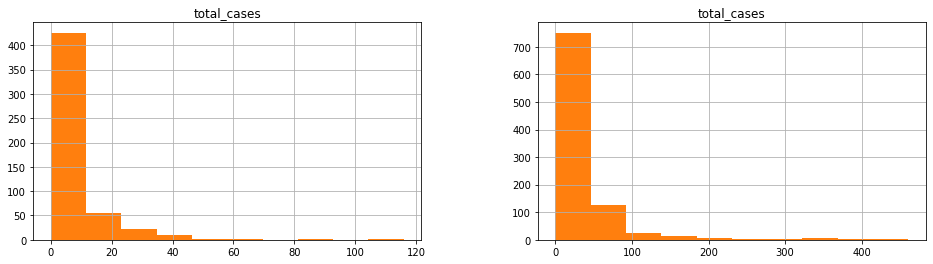

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
iq_train_labels.hist(ax=ax1)
sj_train_labels.hist(ax=ax2)
ax1.set_title('Iquitos', fontsize=18)
ax2.set_title('San Juan', fontsize=18)
iq_train_labels.hist(ax=ax1)
sj_train_labels.hist(ax=ax2)

[Text(0, 0.5, 'frequency')]

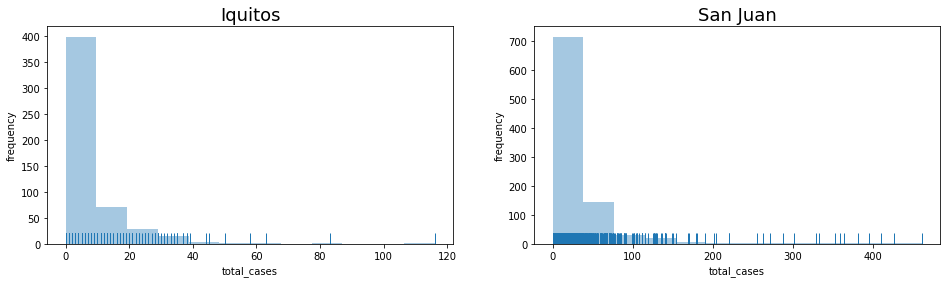

In [10]:
#again adding "rug" marks
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.distplot(iq_train_labels.total_cases, bins=12, kde=False, rug=True, ax=ax1)
sns.distplot(sj_train_labels.total_cases, bins=12, kde=False, rug=True, ax=ax2)
ax1.set_title('Iquitos', fontsize=18)
ax2.set_title('San Juan', fontsize=18)
ax1.set(ylabel='frequency')
ax2.set(ylabel='frequency')

In [11]:
#add in total cases for the correlation matrix
sj_train_features['total_cases'] = sj_train_labels.total_cases
iq_train_features['total_cases'] = iq_train_labels.total_cases

In [12]:
# compute the correlations
sj_correlations = sj_train_features.corr()
iq_correlations = iq_train_features.corr()

Text(0.5, 1, 'San Juan Variable Correlations')

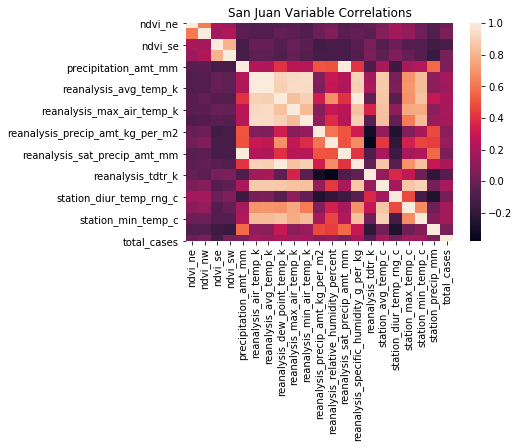

In [13]:
# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations)
plt.title('San Juan Variable Correlations')

Text(0.5, 1, 'Iquitos Variable Correlations')

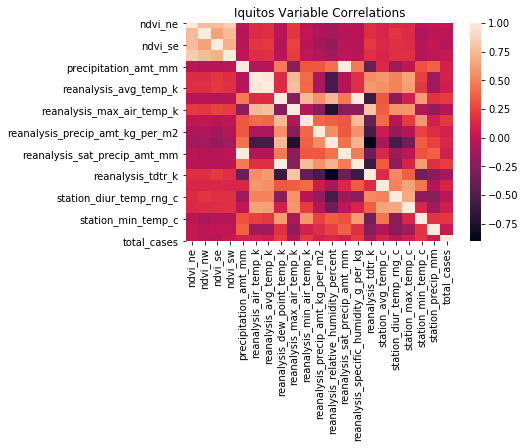

In [14]:
# plot iquitos
iq_corr_heat = sns.heatmap(iq_correlations)
plt.title('Iquitos Variable Correlations')

### explore correlations between features and total cases only

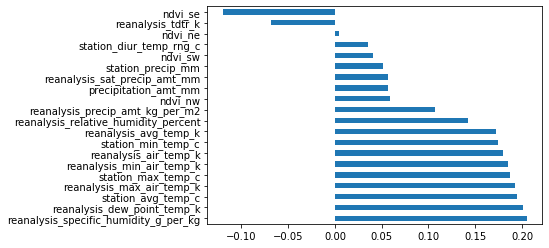

In [15]:
# San Juan
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

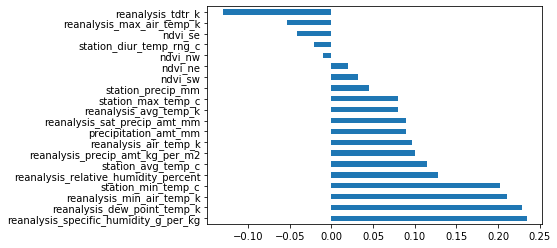

In [16]:
# Iquitos
(iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

#### Unfortunately, the variables don't look very correlated to total cases for either city.

### lasso - did not work well

In [17]:
def preprocess_data(data_path, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])
    
    # select features we want
    features = ['ndvi_ne',
     'ndvi_nw',
     'ndvi_se',
     'ndvi_sw',
     'precipitation_amt_mm',
     'reanalysis_air_temp_k',
     'reanalysis_avg_temp_k',
     'reanalysis_dew_point_temp_k',
     'reanalysis_max_air_temp_k',
     'reanalysis_min_air_temp_k',
     'reanalysis_precip_amt_kg_per_m2',
     'reanalysis_relative_humidity_percent',
     'reanalysis_sat_precip_amt_mm',
     'reanalysis_specific_humidity_g_per_kg',
     'reanalysis_tdtr_k',
     'station_avg_temp_c',
     'station_diur_temp_rng_c',
     'station_max_temp_c',
     'station_min_temp_c',
     'station_precip_mm']
   
    df = df[features]
    
    # fill missing values
    df.fillna(method='ffill', inplace=True)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        df = df.join(labels)
    
    # separate san juan and iquitos
    sj = df.loc['sj']
    iq = df.loc['iq']
    
    return sj, iq

In [18]:
sj_train, iq_train = preprocess_data('dengue_features_train.csv',
                                    labels_path="dengue_labels_train.csv")

In [19]:
sj_train_subtrain = sj_train.head(800)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 800)

iq_train_subtrain = iq_train.head(400)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 400)

In [20]:
sj_labels_subtrain=sj_train_subtrain.pop('total_cases')
sj_labels_subtest=sj_train_subtest.pop('total_cases')

In [21]:
from sklearn import linear_model
from sklearn.linear_model import Lasso

In [22]:
lasso = linear_model.Lasso()
lasso.fit(sj_train_subtrain, sj_labels_subtrain)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [23]:
prediction = lasso.predict(sj_train_subtest)
err = prediction - sj_labels_subtest
R2 = 1-np.var(err)/np.var(sj_labels_subtest)
R2

0.18725543628259878

In [24]:
#find a better alpha
score =[]
best_score = 0
best_alpha= 0
for i in np.linspace(0,100,1000):
    lasso = Lasso(alpha=i).fit(sj_train_subtrain, sj_labels_subtrain)
    prediction = lasso.predict(sj_train_subtest)
    err = prediction - sj_labels_subtest
    score = 1-np.var(err)/np.var(sj_labels_subtest)
    
    
    if score > best_score:
        best_alpha = i
        best_score = score

print('best alpha = ', best_alpha)
print('best score = ', best_score)

best alpha =  0.8008008008008008
best score =  0.18842956742867456


In [25]:
lasso.coef_

array([-0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.08044622,  0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

##### we're not going to get good count predictions with this. 
#### moving on to a decision tree 

In [27]:
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import GridSearchCV

In [28]:
#define features
features = ['ndvi_ne',
     'ndvi_nw',
     'ndvi_se',
     'ndvi_sw',
     'precipitation_amt_mm',
     'reanalysis_air_temp_k',
     'reanalysis_avg_temp_k',
     'reanalysis_dew_point_temp_k',
     'reanalysis_max_air_temp_k',
     'reanalysis_min_air_temp_k',
     'reanalysis_precip_amt_kg_per_m2',
     'reanalysis_relative_humidity_percent',
     'reanalysis_sat_precip_amt_mm',
     'reanalysis_specific_humidity_g_per_kg',
     'reanalysis_tdtr_k',
     'station_avg_temp_c',
     'station_diur_temp_rng_c',
     'station_max_temp_c',
     'station_min_temp_c',
     'station_precip_mm']

In [29]:
#perform grid search

x = train_features[features]
y = train_labels['total_cases']

clf = DecisionTreeRegressor()
clf.fit(x,y) 

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [30]:
importances=clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 3 (0.359982)
2. feature 2 (0.141968)
3. feature 9 (0.111915)
4. feature 7 (0.045324)
5. feature 14 (0.042051)
6. feature 19 (0.037490)
7. feature 0 (0.035471)
8. feature 6 (0.035087)
9. feature 18 (0.032254)
10. feature 1 (0.026418)
11. feature 16 (0.024916)
12. feature 15 (0.016679)
13. feature 13 (0.014116)
14. feature 17 (0.014019)
15. feature 10 (0.013539)
16. feature 11 (0.012185)
17. feature 8 (0.011189)
18. feature 5 (0.008997)
19. feature 4 (0.008764)
20. feature 12 (0.007635)


Text(0.5, 0, 'index of the feature')

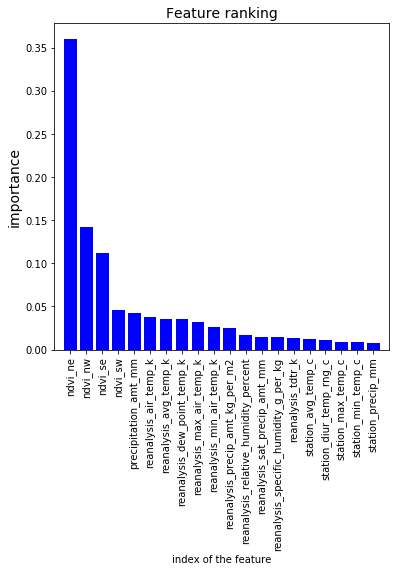

In [31]:
feature_names = x.columns

f, ax = plt.subplots(figsize=(6, 6))
plt.title("Feature ranking", fontsize = 14)
plt.bar(range(x.shape[1]), importances[indices],
    color="b", 
    align="center")
plt.xticks(range(x.shape[1]), feature_names, rotation=90 )
plt.xlim([-1, x.shape[1]])
plt.ylabel("importance", fontsize = 14)
plt.xlabel("index of the feature", fontsize = 10)

### repeat, reducing features to those that had higher correlations and adding grid search

In [32]:
#define features
features = [
     'reanalysis_dew_point_temp_k',
     'reanalysis_specific_humidity_g_per_kg',
     'reanalysis_min_air_temp_k',
     'reanalysis_precip_amt_kg_per_m2',
     'station_avg_temp_c',
     'station_min_temp_c',
     'station_precip_mm']

In [33]:
#perform grid search

x = train_features[features]
y = train_labels['total_cases']


parameters = {"min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              'max_features': ["auto", "sqrt", "log2"]
             
             }


clf = GridSearchCV(DecisionTreeRegressor(), parameters, n_jobs=4)
clf.fit(x,y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

-0.02706755599489455 {'max_depth': 2, 'max_features': 'sqrt', 'max_leaf_nodes': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [34]:
importances=tree_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 2 (0.861707)
2. feature 0 (0.115862)
3. feature 1 (0.022431)
4. feature 6 (0.000000)
5. feature 5 (0.000000)
6. feature 4 (0.000000)
7. feature 3 (0.000000)


Text(0.5, 0, 'index of the feature')

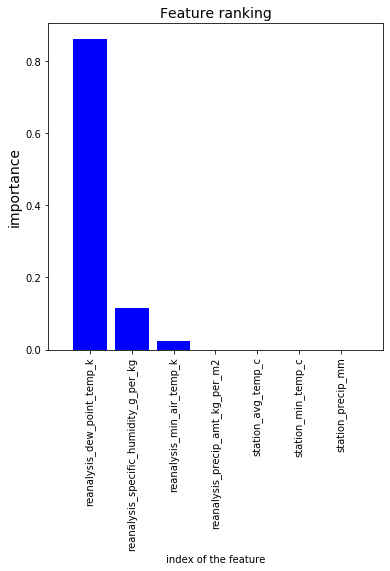

In [35]:
feature_names = x.columns

f, ax = plt.subplots(figsize=(6, 6))
plt.title("Feature ranking", fontsize = 14)
plt.bar(range(x.shape[1]), importances[indices],
    color="b", 
    align="center")
plt.xticks(range(x.shape[1]), feature_names, rotation=90 )
plt.xlim([-1, x.shape[1]])
plt.ylabel("importance", fontsize = 14)
plt.xlabel("index of the feature", fontsize = 10)

#### lets use this as a the benchmark

In [36]:
test=pd.read_csv('dengue_features_test.csv')
test.fillna(method='ffill', inplace=True)

In [38]:
preds = tree_model.predict(test[features])

submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])
submission.total_cases = np.concatenate([preds])

In [39]:
submission['total_cases']=submission['total_cases'].astype(int)
#submission

In [40]:
submission.to_csv("submissions/dt.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'submissions/dt.csv'

### mean absolute error of benchmark 35.8606

#### visualize how the decision tree predictions look on the time series data - wonky!

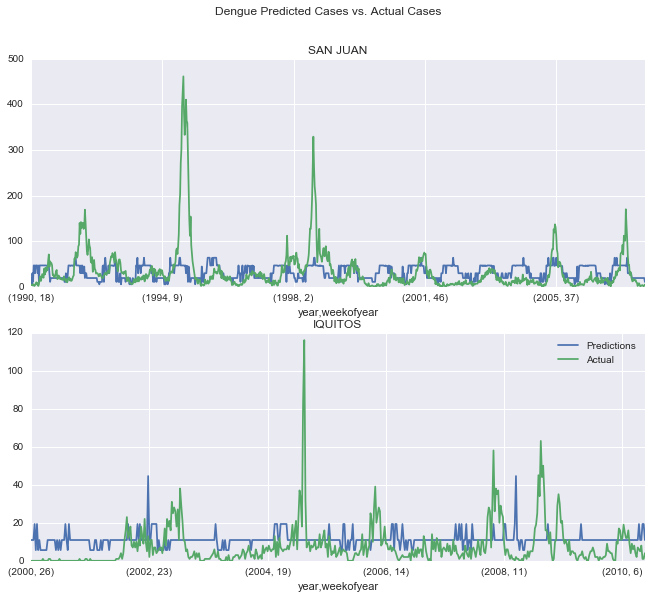

In [39]:
figs, axes = plt.subplots(nrows=2, ncols=1,figsize=(11, 9))

# plot sj
sj_train_features['fitted'] = tree_model.predict(sj_train_features[features])
sj_train_features.fitted.plot(ax=axes[0], label="Predictions")
sj_train_labels.total_cases.plot(ax=axes[0], label="Actual", title="SAN JUAN")

# plot iq
iq_train_features['fitted'] = tree_model.predict(iq_train_features[features])
iq_train_features.fitted.plot(ax=axes[1], label="Predictions")
iq_train_labels.total_cases.plot(ax=axes[1], label="Actual", title="IQUITOS")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

### MAE and MSE of benchmark decision tree model

In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("MAE San Juan:", mean_absolute_error(sj_train_labels['total_cases'], sj_train_features['fitted']))
print("MSE San Juan:", mean_squared_error(sj_train_labels['total_cases'], sj_train_features['fitted']))
print("MAE Iquitos:", mean_absolute_error(iq_train_labels['total_cases'], iq_train_features['fitted']))
print("MSE Iquitios:", mean_squared_error(iq_train_labels['total_cases'], iq_train_features['fitted']))

MAE San Juan: 26.8174748129
MSE San Juan: 2495.11633476
MAE Iquitos: 8.65264134076
MSE Iquitios: 138.90721765
